In [1]:
import abtem
import ase
import matplotlib.pyplot as plt
from ase.io import write

(examples:4d-stem_quickstart)=
# 4D-STEM quickstart

This notebook demonstrates a basic 4D-stem simulation of MoS<sub>2</sub>.

## Configuration

We start by (optionally) setting our configuration. See [documentation](reference:configuration) for details.

In [2]:
abtem.config.set(
    {
        "device": "cpu",
        "fft": "fftw",
        "diagnostics.task_progress": True,
        "diagnostics.progress_bar": "tqdm",
    }
)

## Atomic model

We create the atomic model. See our [walkthough](walkthrough:atomic_models) or our [tutorial](tutorials:advanced_atomic_models) on atomic models. 

We create an atomic model of silicon using the [`mx2` function](https://wiki.fysik.dtu.dk/ase/ase/build/surface.html#ase.build.mx2) from ASE. The structure is repeated in order to improve the reciprocal space sampling of the simulation.

(<Figure size 640x480 with 1 Axes>, <Axes: xlabel='x [Å]', ylabel='y [Å]'>)

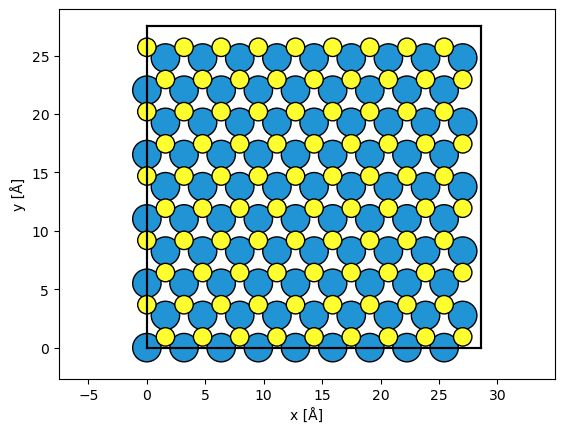

In [3]:
atoms = ase.build.mx2("WS2", vacuum=2)

atoms = abtem.orthogonalize_cell(atoms)

atoms = atoms * (9, 5, 1)

abtem.show_atoms(atoms)

## Potential

We create an ensemble of potentials using the frozen phonon. See our [walkthrough on frozen phonons](walkthrough:frozen_phonons). 

In [4]:
frozen_phonons = abtem.FrozenPhonons(atoms, 8, sigmas=0.1)

We create a potential from the frozen phonons model, see [walkthrough on potentials](walkthrough:potentials).

In [5]:
potential = abtem.Potential(frozen_phonons, sampling=0.05)

## Wave function

We create a probe wave function at an energy of $80 \ \mathrm{keV}$, an objective aperture of $12 \ \mathrm{mrad}$. See our [walkthrough on wave functions](walkthrough:wave_functions).

Partial temporal coherence is neglected here, see our [tutorial on partial coherence](tutorials:partial_coherence). 

In [6]:
probe = abtem.Probe(energy=80e3, semiangle_cutoff=14)
probe.grid.match(potential)

tasks:   0%|          | 0/2 [00:00<?, ?it/s]

tasks:   0%|          | 0/2 [00:00<?, ?it/s]

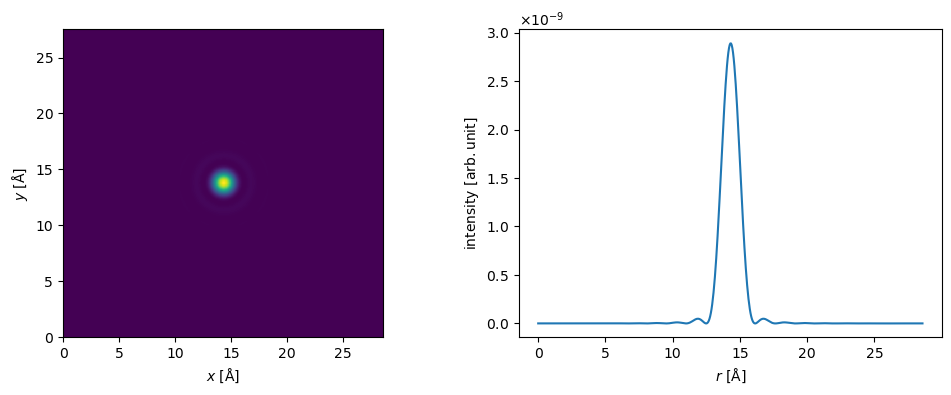

In [7]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
probe.show(ax=ax1)
probe.profiles().show(ax=ax2);

## Scan

We select a scan region using fractional coordinates. We scan at the Nyquist frequency, although there is no real reason to do that in a 4D-STEM simulation.

In [8]:
grid_scan = abtem.GridScan(
    start=[0, 0],
    end=[1 / 9, 1 / 5],
    fractional=True,
    potential=potential,
)

## Detect

We use a flexible annular detector, this will let us choose the detector angles after the running multislice.

In [9]:
detector = abtem.PixelatedDetector()

We set up the scanned multislice simulation. See our [walkthrough on scanning and detecting](walkthrough:scan_and_detect).

In [10]:
measurements = probe.scan(potential, scan=grid_scan, detectors=detector)
measurements.array

dask.array<mean_agg-aggregate, shape=(5, 8, 269, 259), dtype=float32, chunksize=(5, 8, 269, 259), chunktype=numpy.ndarray>

We run the simulation directly to disk.

In [11]:
measurements.to_zarr("4d-stem_quickstart.zarr", compute=True)

tasks:   0%|          | 0/41 [00:00<?, ?it/s]

  0%|          | 0/320 [00:00<?, ?it/s]

  0%|          | 0/320 [00:00<?, ?it/s]

  0%|          | 0/320 [00:00<?, ?it/s]

  0%|          | 0/320 [00:00<?, ?it/s]

  0%|          | 0/320 [00:00<?, ?it/s]

  0%|          | 0/320 [00:00<?, ?it/s]

  0%|          | 0/320 [00:00<?, ?it/s]

  0%|          | 0/320 [00:00<?, ?it/s]

[[None]]

The data is read back lazily. We load it into memory using `.compute`.

In [12]:
measurements = abtem.from_zarr("4d-stem_quickstart.zarr").compute()

tasks:   0%|          | 0/1 [00:00<?, ?it/s]

## Post-processing

We can simulate partial spatial coherence by applying a gaussian filter. The standard deviation of the filter is $0.3 \ \mathrm{Å}$, the approximate size of the electron source.

In [13]:
filtered_measurements = measurements.gaussian_source_size(0.3)

Partial temporal coherence is neglected here, see our [tutorial on partial coherence](tutorials:partial_coherence) if you want to include this in your simulation.

In [14]:
noisy_measurements = filtered_measurements.poisson_noise(dose_per_area=1e6)

We show one of the diffraction patterns below. To see the signal outside the bright field disk it may be necessary to block it.

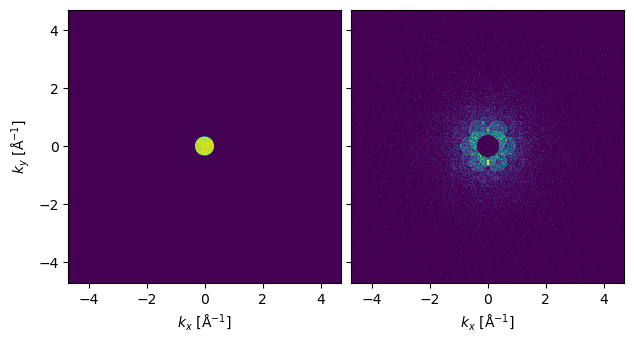

In [15]:
abtem.stack((noisy_measurements[0, 0], noisy_measurements[0, 0].block_direct())).show(
    explode=True, title=None
)

We can show the entire dataset as an exploded plot. If the dataset is large we can use numpy indexing to select every *n*'th diffraction pattern.

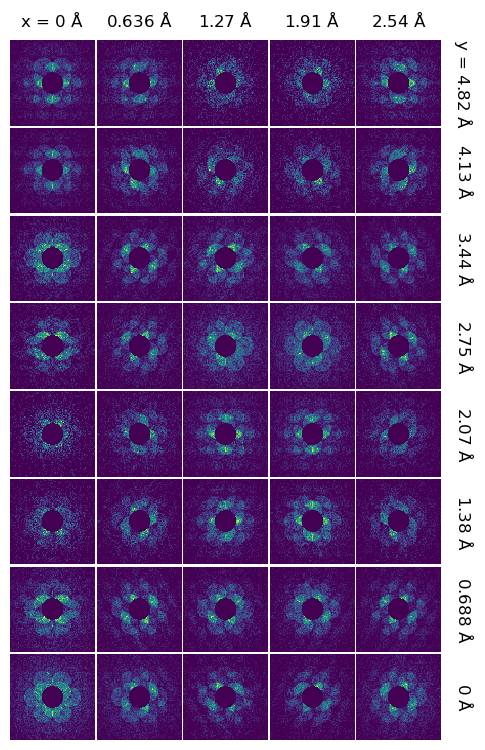

In [16]:
visualization = (
    noisy_measurements[::1, ::1]
    .block_direct()
    .crop(60)
    .show(explode=True, figsize=(8, 8))
)
visualization.axis_off()
visualization.axes.set_sizes(padding=0.02)

## Reduction

*ab*TEM features a few builtin methods for reducing 4D-stem dataset. For more sophisticated methods, see for example [py4DSTEM](https://github.com/py4dstem/py4DSTEM) or [pyxem](https://github.com/pyxem/pyxem).

We can of course integrate the 4D-STEM dataset to get a ADF signal.

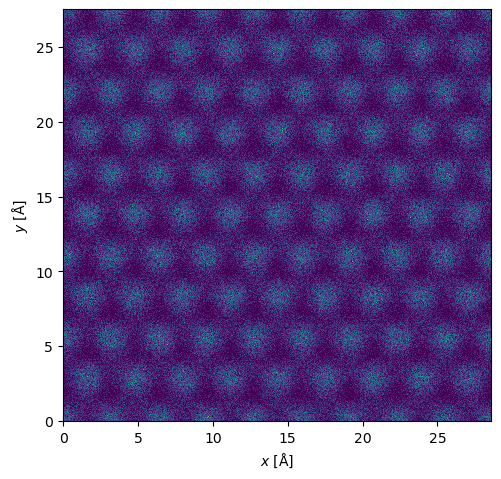

In [17]:
maadf = (
    filtered_measurements.integrate_radial(50, 150)
    .interpolate(0.05)
    .tile((9, 5))
    .poisson_noise(dose_per_area=1e5)
)

maadf.show()

We can get the center of mass and integrated center of mass.

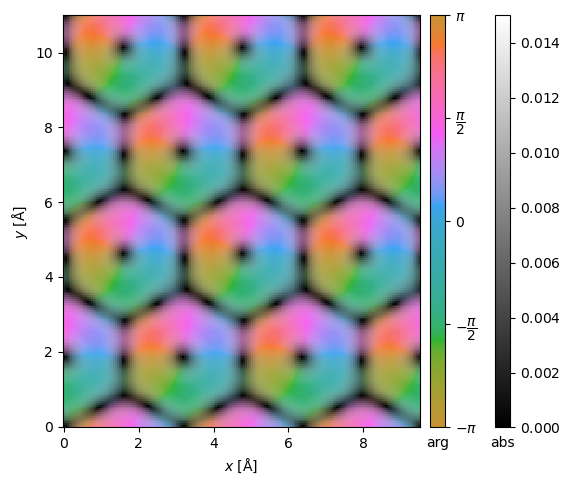

In [18]:
center_of_mass = filtered_measurements.center_of_mass()

interpolated_center_of_mass = center_of_mass.interpolate(0.05).tile((3, 2))

interpolated_center_of_mass.show(cbar=True, vmax=0.015, vmin=0);

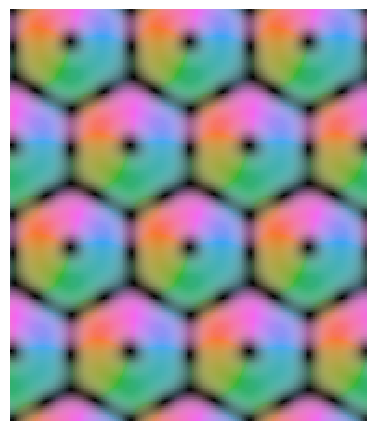

In [19]:
# this cell produces a thumbnail for the online documentation

visualization = interpolated_center_of_mass.show(vmax=0.015, vmin=0.00)
visualization.axis_off()
plt.savefig(
    "../thumbnails/4d-stem_quickstart.png",
    bbox_inches="tight",
    pad_inches=0,
)